In [34]:
import pandas as pd
from tqdm import tqdm
from collections import Counter
import math
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=4, progress_bar=True)

result_df = []
matrix_strategy = 'cumulative'
date = '2026-02-06'
for run in tqdm(range(0, 600, 100)):
    result_dict = pd.read_pickle(f'progressive_matrices/{matrix_strategy}/validation_dumping_dict_{date}/validation_stats_run_{run}.pkl')
    df = pd.DataFrame.from_dict(result_dict, orient='index').T
    result_df.append(df)
    
result_df = pd.concat(result_df).reset_index(drop = True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.66s/it]


In [36]:
result_df['variances'].nunique()

512

In [19]:
content_popularity_tag = pd.read_csv('Content_popularity_tag_26Jan_to_1Feb.csv')
content_popularity_tag.drop_duplicates(subset=['sub_title_id'], inplace = True)
content_popularity_tag.reset_index(drop = True, inplace = True)
content_popularity_dict = content_popularity_tag.set_index('sub_title_id')['popularity_tag'].to_dict()    

result_df['popularity_category'] = result_df['content_ids'].apply(lambda x: content_popularity_dict.get(int(x)))
result_df['popularity_category'] = result_df['popularity_category'].fillna('Unmapped')

In [20]:
result_df.shape, result_df['dw_p_ids'].nunique()

((307200, 7), 45943)

In [21]:
result_df.groupby(['dw_p_ids','timestamps'])['content_ids'].count().describe(percentiles = [x/10 for x in range(10)])

count    46152.000000
mean         6.656266
std          2.286442
min          5.000000
0%           5.000000
10%          5.000000
20%          5.000000
30%          5.000000
40%          6.000000
50%          6.000000
60%          6.000000
70%          7.000000
80%          8.000000
90%          9.000000
max         66.000000
Name: content_ids, dtype: float64

In [22]:
from sklearn.metrics import ndcg_score
import numpy as np

def calculate_ndcg(group, predictions, labels, k_val = [1, 3, 5]):
    if len(group) < k_val[-1]:
        return {}
    
    y_true = np.asarray([group[labels].values.astype(float)])
    y_score = np.asarray([group[predictions].values.astype(float)])
    
    if len(np.unique(y_true)) == 1:
        return {f'NDCG@{k}': 0 for k in k_val}
            
    return {f'NDCG@{k}': ndcg_score(y_true, y_score, k=k) for k in k_val}

def popularity_dist_at_rank(df, score, k_val = [1, 3, 5]):
    df[score] = df[score].astype(float)
    df['rank'] = df.groupby(['dw_p_ids', 'timestamps'])[score].rank(ascending = False)
    
    popularity_dist_dict = {}
    for k in k_val:
        tmp = df[df['rank'] <= k].reset_index(drop = True)
        distribution_dict = tmp.groupby('popularity_category')['content_ids'].count().to_dict()
        popularity_dist_dict[f'Popularity distribution @ {k}'] = {k: round(100 * (v/sum(distribution_dict.values())), 2) for k, v in distribution_dict.items()}
    return popularity_dist_dict

def unique_catalog_at_rank(df, score, k_val = [1, 3, 5]):
    df[score] = df[score].astype(float)
    df['rank'] = df.groupby(['dw_p_ids', 'timestamps'])[score].rank(ascending = False)
    
    catalog_share_dict = {}
    for k in k_val:
        tmp = df[df['rank'] <= k].reset_index(drop = True)
        unique_catalog = tmp['content_ids'].nunique()
        catalog_share_dict[f'Catalog Length @ {k}'] = unique_catalog
    return catalog_share_dict
    
def perplexity_at_rank(df, score, k_val = [1, 3, 5]):
    df[score] = df[score].astype(float)
    df['rank'] = df.groupby(['dw_p_ids', 'timestamps'])[score].rank(ascending = False)
    
    perplexity_at_k_dict = {}
    for k in k_val:
        content_list = df[df['rank'] == k]['content_ids'].values
        p_dist = {k: v/len(content_list) for k,v in dict(Counter(content_list)).items()}
        cross_entropy = -sum([x*math.log2(x) for x in p_dist.values()])
        perplexity = 2**cross_entropy
        perplexity_at_k_dict[f'Perplexity @ {k}'] = perplexity
    return perplexity_at_k_dict

In [23]:
result_df.isna().sum()

dw_p_ids               0
timestamps             0
content_ids            0
deepFMpredictions      0
labels                 0
variances              0
popularity_category    0
dtype: int64

In [24]:
result_df.dropna(inplace = True)

<AxesSubplot:>

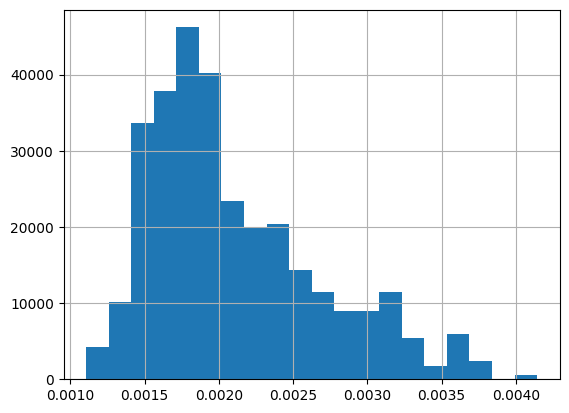

In [25]:
result_df['variances'].hist(bins = 20)

<AxesSubplot:>

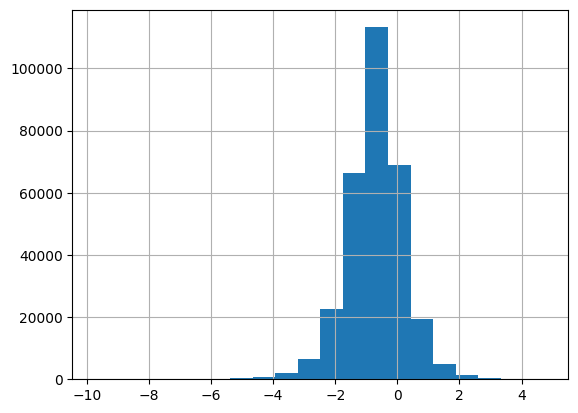

In [26]:
result_df['deepFMpredictions'].hist(bins = 20)

In [27]:
tqdm.pandas()

mu_variances = result_df['variances'].mean()
sigma_variances = result_df['variances'].std()

mu_deepFMscore = result_df['deepFMpredictions'].mean()
sigma_deepFMscore = result_df['deepFMpredictions'].std()

In [28]:
(mu_deepFMscore, sigma_deepFMscore)

(-0.7108815511067709, 0.9317148100690604)

In [29]:
result_df['variances_rescaled'] = result_df['variances'].progress_apply(lambda x: ((x - mu_variances) / sigma_variances) * sigma_deepFMscore + mu_deepFMscore)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 307200/307200 [00:00<00:00, 818183.03it/s]


<AxesSubplot:>

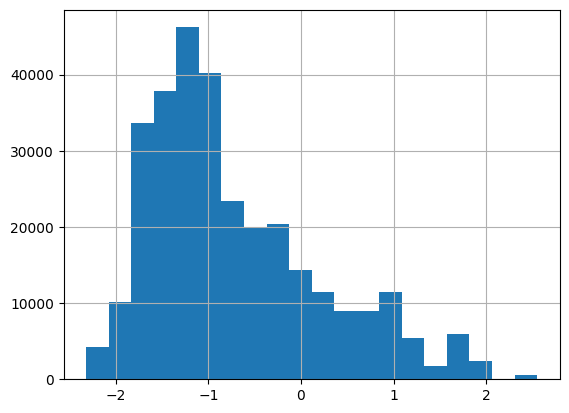

In [30]:
result_df['variances_rescaled'].hist(bins = 20)

In [31]:
result_df.groupby('popularity_category')['variances_rescaled'].mean()

popularity_category
High                  -0.713966
Low                   -0.711194
Medium                -0.710614
Negligible            -0.715140
Unmapped              -0.697598
Weekly New Releases   -0.692613
Name: variances_rescaled, dtype: float64

In [32]:
def evaluation_summary(df, alpha = 1, beta = 1, k_val = [1, 3, 5]):
    df['new_score'] = alpha * df['deepFMpredictions'] + beta * df['variances_rescaled']

    ndcg_results = result_df.groupby(['dw_p_ids', 'timestamps']).parallel_apply(
        lambda x: calculate_ndcg(x, predictions = 'new_score', labels = 'labels')
    ).reset_index(name=f'ndcg_score')
    ndcg_dict = pd.json_normalize(ndcg_results['ndcg_score']).mean().to_dict()
    
    print(f'NDCG for this approach : {ndcg_dict}')

    popularity_dist_dict = popularity_dist_at_rank(df.copy(), 'new_score', k_val = k_val)
    print(f'Popularity category distribution: {popularity_dist_dict}')
    
    catalog_dict = unique_catalog_at_rank(result_df, 'new_score', k_val = k_val)
    print(f'Catalog length distribution: {catalog_dict}')
    
    perplexity_at_k = perplexity_at_rank(result_df, 'new_score', k_val = k_val)
    print(f'Perplexity distribution: {perplexity_at_k}')
    
evaluation_summary(result_df, alpha=1, beta=0)

NDCG for this approach : {'NDCG@1': 0.40747963251863406, 'NDCG@3': 0.5244070590236587, 'NDCG@5': 0.632751407491365}
Popularity category distribution: {'Popularity distribution @ 1': {'High': 14.56, 'Low': 27.94, 'Medium': 39.42, 'Negligible': 7.56, 'Unmapped': 0.01, 'Weekly New Releases': 10.5}, 'Popularity distribution @ 3': {'High': 10.63, 'Low': 32.81, 'Medium': 43.11, 'Negligible': 8.05, 'Unmapped': 0.01, 'Weekly New Releases': 5.39}, 'Popularity distribution @ 5': {'High': 8.82, 'Low': 36.11, 'Medium': 42.39, 'Negligible': 8.64, 'Unmapped': 0.01, 'Weekly New Releases': 4.05}}
Catalog length distribution: {'Catalog Length @ 1': 3391, 'Catalog Length @ 3': 5105, 'Catalog Length @ 5': 5870}
Perplexity distribution: {'Perplexity @ 1': 657.3276693337018, 'Perplexity @ 3': 1289.064064995146, 'Perplexity @ 5': 1477.051921920271}


In [33]:
evaluation_summary(result_df, alpha=0, beta=1)

NDCG for this approach : {'NDCG@1': 0.2745059802392096, 'NDCG@3': 0.40033217646931424, 'NDCG@5': 0.537056787943441}
Popularity category distribution: {'Popularity distribution @ 1': {'High': 8.11, 'Low': 37.9, 'Medium': 41.0, 'Negligible': 9.24, 'Unmapped': 0.01, 'Weekly New Releases': 3.74}, 'Popularity distribution @ 3': {'High': 8.11, 'Low': 37.91, 'Medium': 40.97, 'Negligible': 9.28, 'Unmapped': 0.01, 'Weekly New Releases': 3.72}, 'Popularity distribution @ 5': {'High': 8.05, 'Low': 37.84, 'Medium': 41.11, 'Negligible': 9.29, 'Unmapped': 0.01, 'Weekly New Releases': 3.7}}
Catalog length distribution: {'Catalog Length @ 1': 4186, 'Catalog Length @ 3': 5456, 'Catalog Length @ 5': 5964}
Perplexity distribution: {'Perplexity @ 1': 1367.3957674034657, 'Perplexity @ 3': 1360.9348551733667, 'Perplexity @ 5': 1355.1151565789348}
